# Solving ODE's with a Physics Inspired Neural Network
This notebook demonstrates how we can using physics inspired machine learning to solve differential equations.

## First Order ODE
A first-order ODE has the form
$$ 
\frac{dy}{dx} + P(x)y = Q(x)
$$

Consider a specific example, where
$$
\frac{dy}{dx} - 2y = e^{3x}
$$

which has a general solution
$$
y = e^{3x} + Ce^{2x}
$$

If we take the initial condition (IC) as $(x=0, y=1)$, then $y=e^{3x}$ is our desired solution.

We can approach this problem using a physics-inspired neural network. First we define our loss from the PDE ($L_{PDE}$), and our loss from the data which is the initial condition ($L_{data}$). The overall loss is

$$
L = L_{PDE} + L_{data}
$$

Let $f(x)$ be the neural network. Optimizing so that $\frac{dy}{dx} - 2y - e^{3x}$ is as close to 0 as possible, we define
$$
L_{PDE} = \frac{1}{n}\sum_{i=1}^n\left(\frac{df(x)}{dx}\Bigr|_{x=x_i} - 2f(x_i) - e^{3x_i}\right)^2
$$

On the other hand, we define $L_{data}$ so that the neural network $f(x)$ matches the observed initial condition $(x=0, y=1)$
$$ 
L_{data} = (f(0) - 1)^2
$$

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class FirstOrderNet(nn.Module):
    """Single layer PINN to solve first order ODE example"""
    def __init__(self):
        super(FirstOrderNet, self).__init__()
        # Feed-forward layers
        self.linear1 = nn.Linear(1, 10) #  10 hidden units
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        # Input tensor x of shape (n, 1)
        out = self.linear1(x) # (n, 10)
        out = self.sigmoid1(out) # (n, 10)
        out = self.linear2(out) # (n, 1)

        # Differentiate according to the ODE (create_graph = True is useful for taking higher-order derivatives)
        dy_dx = torch.autograd.grad(out, x, grad_outputs=torch.ones_like(out), create_graph=True)[0]
        return out, dy_dx

In [3]:
class FirstOrderPINNLoss(nn.Module):
    """
    Implement PINN loss function for first-order ODE example
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y_pred, dy_dx):
        return torch.mean((dy_dx - torch.exp(3 * x) - 2 * y_pred) ** 2)  + (y_pred[0, 0] - 1) ** 2

In [4]:
# Input x
x = np.arange(0, 1, 0.01).reshape(-1, 1) # (100, 1)
x =  torch.tensor(x, dtype=torch.float32, requires_grad=True) # convert to torch tensor

# Instantiate model, criterion, and optimizer
torch.manual_seed(0)
first_order_model = FirstOrderNet()
criterion = FirstOrderPINNLoss()
optimizer = torch.optim.LBFGS(first_order_model.parameters())
epochs = 5 # Number of training epochs

# Train model
def closure():
    """Define closure function to use with LBFGS optimizer"""
    optimizer.zero_grad()   # Clear gradients from previous iteration
    y_pred, dy_dx = first_order_model(x)
    loss = criterion(x, y_pred, dy_dx)
    loss.backward() # Backprogation
    return loss 

def training_loop(epochs):
    """Run full training loop"""
    for i in tqdm(range(epochs), desc='Training epochs: '):
        optimizer.step(closure)

training_loop(epochs=epochs)

Training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training epochs: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s]


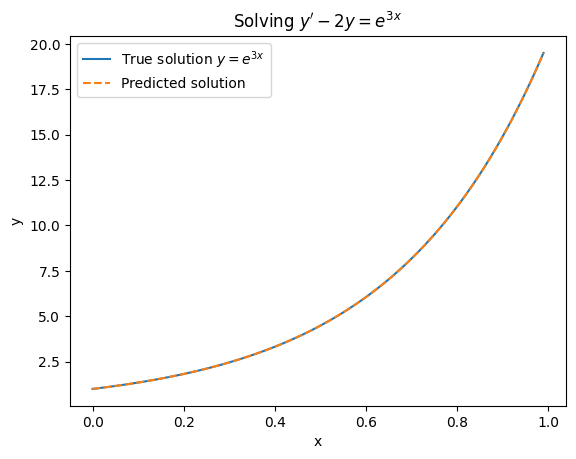

In [5]:
# Plot results
first_order_model.eval()
y_pred, dy_dx = first_order_model(x)
x_grid = x.flatten().detach().numpy()

fig, ax = plt.subplots()
ax.plot(x_grid, np.exp(3 * x_grid), label='True solution $y=e^{3x}$')
ax.plot(x_grid, y_pred.detach().numpy(), ls='dashed', label='Predicted solution')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Solving $y' - 2y = e^{3x}$")
ax.legend()
plt.savefig('figures/first_order_ode.png')
plt.show()

### Trying different optimizers

In [6]:
def training_adam(epochs, x):
    """Training algorithm running Adam"""
    x =  torch.tensor(x, dtype=torch.float32, requires_grad=True) # convert to torch tensor

    # Instantiate model, criterion, and optimizer
    torch.manual_seed(0)
    first_order_model = FirstOrderNet()
    criterion = FirstOrderPINNLoss()
    optimizer1 = torch.optim.Adam(first_order_model.parameters(), lr=1)

    # Define and run training loop
    def training_loop(epochs):
        """Run full training loop"""
        for i in range(epochs):
            optimizer1.zero_grad()
            y_pred, dy_dx = first_order_model(x)
            loss = criterion(x, y_pred, dy_dx)
            loss.backward() # Backprogation
            optimizer1.step()

    training_loop(epochs=epochs)

    # Evaluate model predictions
    y_pred, dy_dx = first_order_model(x)
    return y_pred.detach().numpy().flatten()

In [7]:
def training_adam_lbfgs(epochs, x):
    """Training algorithm running Adam for first half of epochs and LBGFS for the second"""
    x =  torch.tensor(x, dtype=torch.float32, requires_grad=True) # convert to torch tensor

    # Instantiate model, criterion, and optimizer
    torch.manual_seed(0)
    first_order_model = FirstOrderNet()
    criterion = FirstOrderPINNLoss()
    optimizer1 = torch.optim.Adam(first_order_model.parameters(), lr=1)
    optimizer2 = torch.torch.optim.LBFGS(first_order_model.parameters())

    def closure():
        """Define closure function to use with LBFGS optimizer"""
        optimizer2.zero_grad()   # Clear gradients from previous iteration
        y_pred, dy_dx = first_order_model(x)
        loss = criterion(x, y_pred, dy_dx)
        loss.backward() # Backprogation
        return loss 

    # Define and run training loop
    def training_loop(epochs):
        """Run full training loop"""
        for i in range(epochs):
            # start with Adam optimizer
            if i <= epochs / 3:
                optimizer1.zero_grad()
                y_pred, dy_dx = first_order_model(x)
                loss = criterion(x, y_pred, dy_dx)
                loss.backward() # Backprogation
                optimizer1.step()
            # refine solution with LBFGS
            else:
                optimizer2.step(closure)

    training_loop(epochs=epochs)

    # Evaluate model predictions
    y_pred, dy_dx = first_order_model(x)
    return y_pred.detach().numpy().flatten()

In [8]:
def training_lbfgs(epochs, x):
    """Training algorithm running LBGFS algorithm"""
    x =  torch.tensor(x, dtype=torch.float32, requires_grad=True) # convert to torch tensor

    # Instantiate model, criterion, and optimizer
    torch.manual_seed(0)
    first_order_model = FirstOrderNet()
    criterion = FirstOrderPINNLoss()
    optimizer2 = torch.torch.optim.LBFGS(first_order_model.parameters())

    def closure():
        """Define closure function to use with LBFGS optimizer"""
        optimizer2.zero_grad()   # Clear gradients from previous iteration
        y_pred, dy_dx = first_order_model(x)
        loss = criterion(x, y_pred, dy_dx)
        loss.backward() # Backprogation
        return loss 

    # Define and run training loop
    def training_loop(epochs):
        """Run full training loop"""
        for i in range(epochs):
            optimizer2.step(closure)

    training_loop(epochs=epochs)

    # Evaluate model predictions
    y_pred, dy_dx = first_order_model(x)
    return y_pred.detach().numpy().flatten()

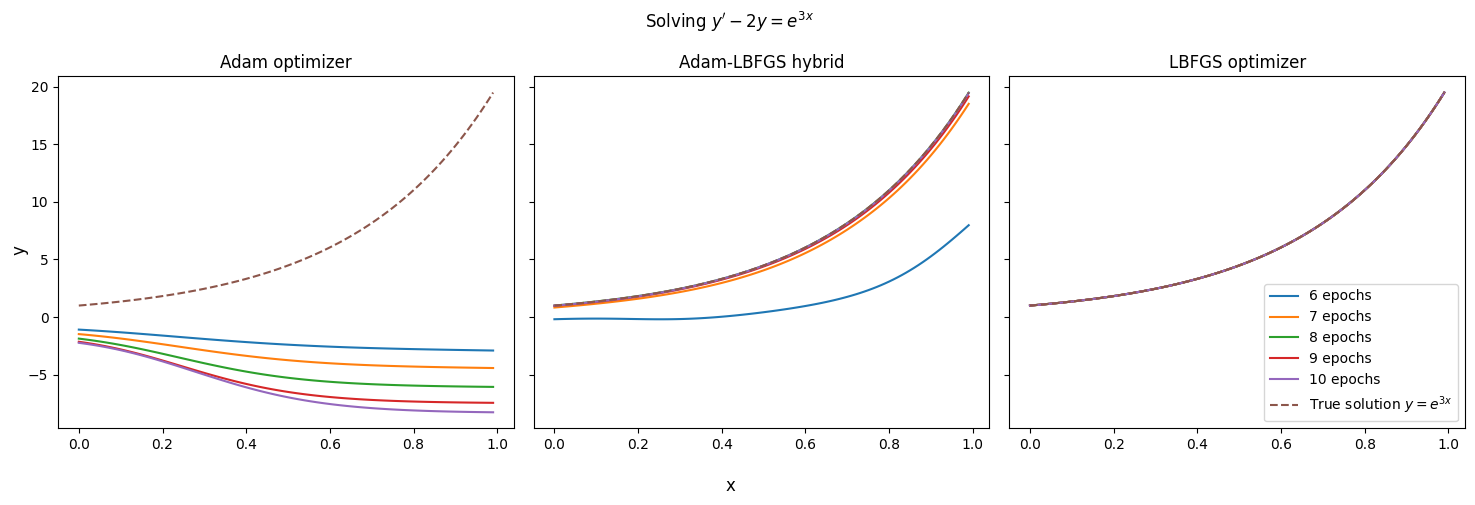

In [9]:
# Plot results
x = np.arange(0, 1, 0.01).reshape(-1, 1) # (100, 1)

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))
for i in range(6, 11):
    axes[0].plot(x.flatten(), training_adam(epochs=i, x=x))
    axes[0].set_title('Adam optimizer')
    axes[1].plot(x.flatten(), training_adam_lbfgs(epochs=i, x=x))
    axes[1].set_title('Adam-LBFGS hybrid')
    axes[2].plot(x.flatten(), training_lbfgs(epochs=i, x=x), label=f'{i} epochs')
    axes[2].set_title('LBFGS optimizer')

axes[0].plot(x.flatten(), np.exp(3 * x.flatten()), ls='--', label='True solution $y=e^{3x}$')
axes[1].plot(x.flatten(), np.exp(3 * x.flatten()), ls='--', label='True solution $y=e^{3x}$')
axes[2].plot(x.flatten(), np.exp(3 * x.flatten()), ls='--', label='True solution $y=e^{3x}$')
axes[2].legend(loc='lower right')


fig.supxlabel('x')
fig.supylabel('y')
fig.suptitle("Solving $y' - 2y = e^{3x}$")
plt.tight_layout()
plt.show()